## Phrase-based Image Search
### Input: a query phrase 
####_(i.e. "in the sky")_

### Output: image search results for the input query 
####_(i.e. presumably images of airplanes, kites, etc. in the sky)_

In [1]:
# normal python
import os
import numpy as np

# visualizing
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imread

# local imports
from dataset import cocoXYFilenames, GloveTransformer
from utils import ModelIO, npy2jpg
import pipeline
from config import MODEL_FILES_DIR, COCO_DIR

MLB loaded from file
Tokenizer loaded from file.


Using gpu device 0: GeForce GTX 980


In [2]:
# Load Image-Caption Data Stream
X, Y, filenames = cocoXYFilenames(dataType='val2014')
sources = ("X", "Y")
sources_k = ("X_k", "Y_k")
stream = pipeline.DataETL.getFinalStream(X, Y, sources=sources,
            sources_k=sources_k, batch_size=10000)
images, captions, _0, _1 = stream.get_epoch_iterator().next()

loading annotations into memory...
Done (t=0.93s)
creating index...
index created!


In [3]:
# Load Joint Image-Caption Encoder
encoder_name = 'project1.jointembedder'
jointembedder_Img = ModelIO.load(os.path.join(MODEL_FILES_DIR, encoder_name + "_Img"))
jointembedder_Txt = ModelIO.load(os.path.join(MODEL_FILES_DIR, encoder_name + "_Txt"))

In [4]:
# Load GloVe Vectors
glove_version = "glove.6B.%sd.txt.gz" % 300
gloveglove = GloveTransformer(glove_version, None, pipeline.vect)

In [5]:
queryText = "in the sky"

In [6]:
def to_text_embedder(inputText):
    words = inputText.split(' ')
    print(words)
    word_seq_vect = []
    for word in words:
        word_seq_vect.append(
            gloveglove.vectors[gloveglove.lookup[word]]
            )
    word_seq_vect = np.vstack(word_seq_vect)
    word_seq_vect = word_seq_vect[None] # add dimension for batch
    print(word_seq_vect.shape)
    return word_seq_vect

word_seq_vect = to_text_embedder(queryText)

['in', 'the', 'sky']
(1, 3, 300)


In [7]:
# obtain the joint image and phrase embeddings
image_embs = jointembedder_Img(images)
phrase_embs = jointembedder_Txt(word_seq_vect)
print(image_embs.shape)
print(phrase_embs.shape)

(10000, 300)
(1, 300)


In [8]:
def get_similarities(imgs, query):
    # l2 norm the image embedding
    for i in range(len(imgs)):
        imgs[i] /= np.linalg.norm(imgs[i])

    # l2 norm the text embedding
    for i in range(query.shape[0]):
        query[i] /= np.linalg.norm(query[i])

    # cosine simliarity (the dot product of l2 normalized vectors)
    return np.dot(query, imgs.T).flatten()

def find_images_from_query(imgs, query, top_n=25):
    """
    Parameters
    ----------
    imgs: array-like, shape (n_candidates, embedding_dim)
    
    query: array-like, shape (1, embedding_dim)
    
    top_n: how many top search results to return
    
    Return
    ------
    found: a list of indexes, sorted by relevance
    
    sims: array-like, shape (n_candidates,)
        cosine similarities for all the images in the pool
    """

    if query.shape[0] != 1:
        print("Query should only be a single phrase. \
               Got %d phrases " % query.shape[0])
        return

    sims = get_similarities(imgs, query)
    
    # get the top_n maximum value indices, sorted
    found = np.argsort(sims)[-top_n:]
    
    return found, sims

found, sims = find_images_from_query(image_embs, phrase_embs)

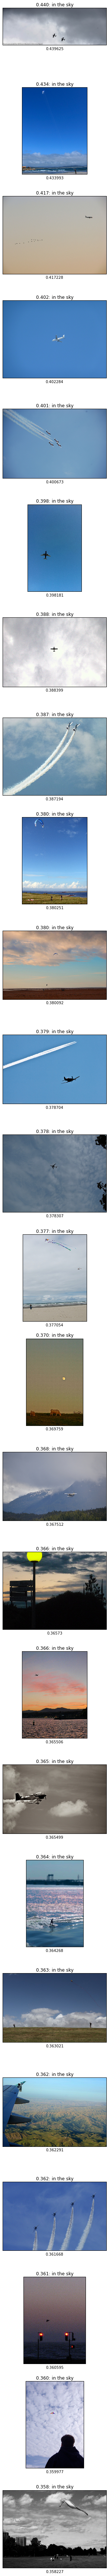

In [9]:
img_path = os.path.join(COCO_DIR, "images/val2014/")

n_found = len(found)

fig, axes = plt.subplots(n_found, 1, figsize=(5, 5*n_found))

for i, idx in enumerate(reversed(found)):
    img_file = npy2jpg(filenames[idx])
    img = imread(os.path.join(img_path, img_file))
    axes[i].imshow(img)
    axes[i].set_title("%.3f: %s" % (sims[idx], queryText))
    axes[i].set_xlabel(sims[idx])
    axes[i].set_xticks([]); axes[i].set_yticks([]);

plt.show()